## simple debug setup

In [ ]:
gdalbuildvrt -sd 42 -input_file_list filelist_org.txt testVirtual_sd_42.vrt

In [ ]:
gdal_translate -of PNG -ot Byte -scale -outsize 10% 10% testVirtual_sd_42.vrt testVirtual_sd_42.png

In [4]:
find /project/return/Share/mm/S1_SA_TEST_UPSCALE/TILE_WISE/AOI_PA/E078N066T3/*/ -name '*D039_VH.nc' > filelist_org.txt

In [ ]:
gdalbuildvrt -sd 42 -input_file_list filelist_org.txt virtualmosaic_subdataset_42.vrt

In [2]:
import os, osr, glob
import xarray as xr
import rioxarray
from rioxarray.merge import merge_datasets, merge_arrays
import numpy as np
import geopandas as gpd
#
from geocube.api import core
#
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
#
import seaborn as sns
#
from equi7grid.equi7grid import Equi7Grid
#%matplotlib widget
#%matplotlib inline

Set the tile, orbit, and polarisation to read:

In [3]:
#myTile = 'E066N060T3' # Rondonia
#myOrbit = 'D156' # Rondonia
#
myTile = 'E078N066T3' # Para
myOrbit = 'D039' # Para
#
myPol = 'VH'

In [4]:
# set the folter wih the output files:
data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  myTile + '_smallChanks'

In [5]:
# Equi7 SA wkt:
PROJ = 'PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["false_easting",7257179.23559],PARAMETER["false_northing",5592024.44605],PARAMETER["central_meridian",-60.5],PARAMETER["latitude_of_origin",-14.0],UNIT["Meter",1.0]]'

In [6]:
# read multiple ckunks:
ChunkDatasetList = []
# set the rwos and columns:
#myCols, myRows = np.meshgrid(np.arange(34, 38), np.arange(42, 46)) # Rondonia
myCols, myRows = np.meshgrid(np.arange(20, 24), np.arange(36, 40)) # Para
# read each one
for myRow, myCol in zip(myRows.flatten(), myCols.flatten()):
    # set filename:
    fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_250_' + myOrbit + '_'+ myPol + '.nc'
    aux_ds = rioxarray.open_rasterio(os.path.join(data_folder, fileName))
    # set crs:
    aux_ds.rio.write_crs(PROJ, inplace=True)
    ChunkDatasetList.append(aux_ds)      

In [7]:
# mearge chanks spatialy:
my_out = merge_datasets(ChunkDatasetList)   

Read forest age and LULC data:

In [8]:
# fileName2 = r'myforAgeLCLU_2017_2020_equi7_E066N060T3_20m.tif' # Rondonia
fileName2 = r'myforAgeLCLU_2017_2020_equi7_E078N066T3_20m.tif' # Para
forAgeLULC = rioxarray.open_rasterio(fileName2, band_as_variable=True)
# convert to dataset:
forAgeLULC_ds = forAgeLULC.to_dataset('band').rename({1: 'forAge2017', 2: 'lulc2018', 3: 'lulc2019', 4: 'forAge2020', 5: 'ECO_ID'})

Correct coordinates (temporary soluton!!!)

In [9]:
forAgeLULC_ds = forAgeLULC_ds.assign_coords(x=forAgeLULC_ds.x - 10 )

In [10]:
forAgeLULC_ds = forAgeLULC_ds.assign_coords(y=forAgeLULC_ds.y + 10 )

Join datasets and clip forAgeLCLU to my_out coordinates:

In [11]:
all_ds = xr.merge([my_out.isel(band=0, drop=True), forAgeLULC_ds], join='inner') 

## Analyse annual statistics

In [12]:
# Add the combined annual statistics:
all_ds['qDiff_2017'] = all_ds['q90_2017'] - all_ds['q10_2017']
all_ds['dRange_2017'] = all_ds['max_2017'] - all_ds['min_2017']
all_ds['iqRange_2017'] = all_ds['q75_2017'] - all_ds['q25_2017']

In [13]:
# set the relevant statistics:
myStatnames = ['mean_2017', 'median_2017', 'std_2017', 'MAD_2017', 'dRange_2017', 'qDiff_2017', 'iqRange_2017', 'forAge2017']
# mearge the arrays into new dataset:
my_ds = all_ds[myStatnames]

In [14]:
# select secondary forest and convert to pandas data frame
my_df = my_ds.where((my_ds['forAge2017'] > 0) & (my_ds['forAge2017'] < 50)).to_dataframe()
# drop unneccery data:
my_df.drop(columns='spatial_ref', inplace=True)
my_df.dropna(subset=['forAge2017'], inplace=True)

Export to scv

In [15]:
# only once:
#my_df.to_csv('Para_dataset.csv')

# Fit multivariate linear regression to original data:

In [16]:
# prepare data for the fit
X = my_df.reset_index().drop(['forAge2017', 'x', 'y'], axis = 1)
y = my_df.reset_index()[['forAge2017']]

In [17]:
lm = LinearRegression()
model = lm.fit(X,y)

In [18]:
model.intercept_

array([13.60174302])

In [19]:
model.coef_

array([[-0.53677084,  0.41808249, -3.25627521,  0.25600791,  0.01745114,
        -0.01275697, -0.12340945]])

In [20]:
model.score(X,y)

0.009995354348979246

In [21]:
MSE = mean_squared_error(y,model.predict(X))
MSE

65.36360931648201

In [22]:
RMSE = np.sqrt(MSE)
RMSE

8.084776392484953

In [23]:
R2 = r2_score(y,model.predict(X))
R2

0.009995354348979246

In [24]:
# group by year:
df_med = my_df.groupby(by='forAge2017').mean()

## Plotting

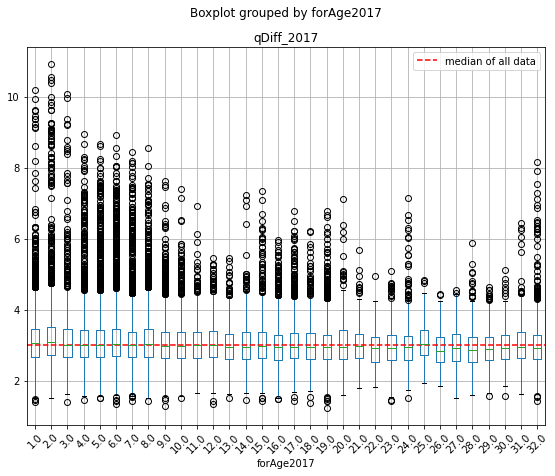

In [25]:
#%matplotlib widget
%matplotlib inline
my_df.boxplot('qDiff_2017', by='forAge2017', grid=True, rot=45, figsize=(9, 7))
# add the parameter value (all data) as horizontal line:
plt.axhline(y=my_df['qDiff_2017'].median(), color='r', linestyle='--', label='median of all data')
plt.legend(loc='upper right')

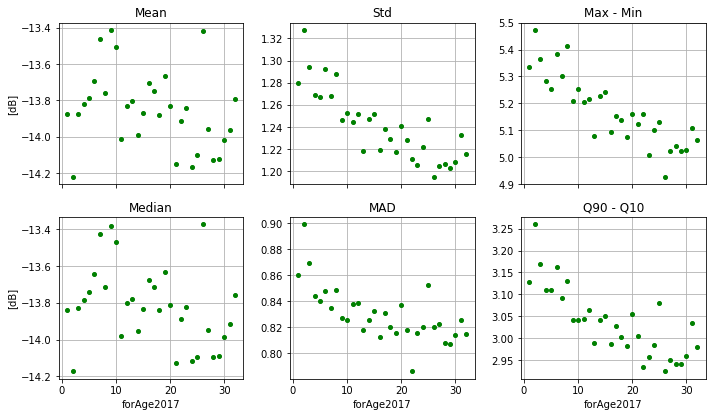

In [26]:
#%matplotlib widget
#%matplotlib inline
#
fig, axs = plt.subplots(2, 3, figsize=(10, 5.9), sharex=True)
# add plots
df_med.mean_2017.plot(style='o', grid=True, ax=axs[0, 0], title='Mean', **{'markersize': 4, 'color':'green'})
df_med.std_2017.plot(style='o', grid=True, ax=axs[0, 1], title='Std', **{'markersize': 4, 'color':'green'})
df_med.dRange_2017.plot(style='o', grid=True, ax=axs[0, 2], title='Max - Min', **{'markersize': 4, 'color':'green'})
#
df_med.median_2017.plot(style='o', grid=True, ax=axs[1, 0], title='Median', **{'markersize': 4, 'color':'green'})
df_med.MAD_2017.plot(style='o', grid=True, ax=axs[1, 1], title='MAD', **{'markersize': 4, 'color':'green'})
df_med.qDiff_2017.plot(style='o', grid=True, ax=axs[1, 2], title='Q90 - Q10', **{'markersize': 4, 'color':'green'})
#
axs[0, 0].set_ylabel('[dB]')
axs[0, 1].set_ylabel('')
axs[0, 2].set_ylabel('')
#
axs[1, 0].set_ylabel('[dB]')
axs[1, 1].set_ylabel('')
axs[1, 2].set_ylabel('')
#
fig.tight_layout()


Calculate the number of forest age pixels

In [27]:
# group by year:
df_count = my_df.groupby(by='forAge2017').mean_2017.count()

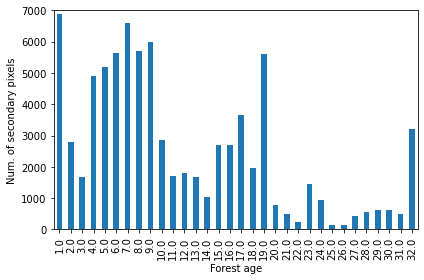

In [28]:
#%matplotlib widget
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
df_count.plot.bar(ax=axs)#
axs.set_xlabel('Forest age')
axs.set_ylabel('Num. of secondary pixels')
axs.set_ylim([0, 7000])
fig.tight_layout()

## Intersect with Emprapa restoration polygons

In [29]:
# load the Embrapa polygons:
df_inSitu = gpd.read_file(r'inSitu/Polygons_restoration_areas.shp')
df_inSitu.head()

,Hectares,Nome_Área,Ano_Planti,Observaç,Método,areas,geometry
0,6.153048,Pau a Pique nº 02,2012,Plantio em manutenção no ano de 2015,Plantio em área total,paupique,"POLYGON ((296317.536 8943041.701, 296044.675 8..."
1,12.790814,Pau a Pique nº 01,2012,Plantio em manutenção no ano de 2015,Plantio em área total,paupique,"POLYGON ((297621.616 8943183.048, 297718.715 8..."
2,3.080031,Pau a Pique nº 03,2012,Plantio em manutenção no ano de 2015,Plantio em área total,paupique,"POLYGON ((297544.186 8943582.409, 297552.651 8..."
3,4.834484,Linha F Nº 01,2013,Plantio em manutenção no ano de 2015,Plantio de enriquecimento,linhaf,"POLYGON ((301903.874 8942110.007, 301995.647 8..."
4,2.288757,Linha F Nº 01,2013,Plantio em manutenção no ano de 2015,Plantio de enriquecimento,linhaf,"POLYGON ((301363.784 8941430.549, 301401.403 8..."


<AxesSubplot:>

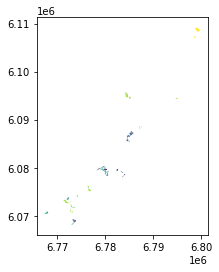

In [30]:
# convert to Equi7 SA projection
df_inSitu = df_inSitu.to_crs(PROJ)
df_inSitu.plot(column='Ano_Planti')

In [31]:
my_ds_clipped = my_ds.rio.clip(df_inSitu.geometry.values)

NoDataInBounds: No data found in bounds. Data variable: mean_2017

In [32]:
my_ds_clipped.mean_2017.plot()

NameError: name 'my_ds_clipped' is not defined

In [ ]:
# convert geopands polygon to xarray dataset matching exsisting xarray dataset
out_grid = core.make_geocube(
    vector_data=df_inSitu,
    measurements=["Ano_Planti"],
    like=my_ds_clipped, # ensure the data are on the same grid
)

In [ ]:
out_grid.Ano_Planti.plot()

In [ ]:
# mearge the xarray datasets:
my_ds_S1_inSitu = xr.merge([out_grid, my_ds_clipped], join='inner') 

In [ ]:
# rename the refernce variable and substruct from 2018
my_ds_S1_inSitu = my_ds_S1_inSitu.rename({'Ano_Planti': 'forAgeRef'})
my_ds_S1_inSitu['forAgeRef'] = 2018 - my_ds_S1_inSitu['forAgeRef']

In [ ]:
# convert to pandas data frame
my_df_S1_inSitu = my_ds_S1_inSitu.to_dataframe()
# drop unneccery data:
my_df_S1_inSitu.drop(columns='spatial_ref', inplace=True)
my_df_S1_inSitu.dropna(subset=['forAge2017'], inplace=True)

In [ ]:
my_df_S1_inSitu

In [ ]:
# group by year:
my_df_S1_inSitu_med = my_df_S1_inSitu.groupby(by='forAgeRef').mean()

In [ ]:
#%matplotlib widget
#%matplotlib inline
#
fig, axs = plt.subplots(2, 3, figsize=(10, 5.9), sharex=True)
# add plots
my_df_S1_inSitu_med.mean_2017.plot(style='o', grid=True, ax=axs[0, 0], title='Mean', **{'markersize': 4, 'color':'green'})
my_df_S1_inSitu_med.std_2017.plot(style='o', grid=True, ax=axs[0, 1], title='Std', **{'markersize': 4, 'color':'green'})
my_df_S1_inSitu_med.dRange_2017.plot(style='o', grid=True, ax=axs[0, 2], title='Max - Min', **{'markersize': 4, 'color':'green'})
#
my_df_S1_inSitu_med.median_2017.plot(style='o', grid=True, ax=axs[1, 0], title='Median', **{'markersize': 4, 'color':'green'})
my_df_S1_inSitu_med.MAD_2017.plot(style='o', grid=True, ax=axs[1, 1], title='MAD', **{'markersize': 4, 'color':'green'})
my_df_S1_inSitu_med.qDiff_2017.plot(style='o', grid=True, ax=axs[1, 2], title='Q90 - Q10', **{'markersize': 4, 'color':'green'})
#
axs[0, 0].set_ylabel('[dB]')
axs[0, 1].set_ylabel('')
axs[0, 2].set_ylabel('')
#
axs[1, 0].set_ylabel('[dB]')
axs[1, 1].set_ylabel('')
axs[1, 2].set_ylabel('')
#
fig.tight_layout()

## Analyse the recovery time:

Select ts with disturbance-recovery pattern 

In [ ]:
# mearge the arrays into new dataset:
mearged_ds = xr.merge([my_out, forAgeLULC_ds])

In [ ]:
#%matplotlib widget
#%matplotlib inline
#
# eception label selection:
# 0 - tipical disturbance (including aklso no recovery!!! see TS_end_flag and TS_end_flag_long)
# 1 - no data
# 2 - no disturbance
# 3 - atipical disturbance (mean TS is above the refernce bounds)
# ------------
# TS_end_flag:
# -1 - below the reference
#  0 - in reference bounds
#  1 - above the reference
# -------------------------------------------------------------------------------
recov_da = mearged_ds.where((mearged_ds.exception_label==0) & (mearged_ds.max_mag>0) & (mearged_ds.TS_end_flag>=0))

In [ ]:
recov_da['t_seg'] = np.fabs(recov_da['t_pre']) + np.fabs(recov_da['t_post'])

In [ ]:
bb = recov_da[['t_seg', 'max_mag']]
#
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=bb.to_dataframe(), x="t_seg", y="max_mag", s=5, color=".15")
sns.histplot(data=bb.to_dataframe(), x="t_seg", y="max_mag", bins=50, 
             pthresh=0.1, cmap="mako", cbar=True, cbar_kws=dict(shrink=.75), stat='percent', 
             log_scale=[False, False])
#sns.kdeplot(data=bb.to_dataframe(), x="t_seg", y="max_mag", levels=5, color="w", linewidths=1)